In [1]:
import os
import torch
import numpy as np
import tempfile
from contextlib import nullcontext

from mast3r.demo import get_args_parser, main_demo, get_reconstructed_scene, set_scenegraph_options
from dust3r.utils.device import to_numpy

from mast3r.cloud_opt.sparse_ga import sparse_global_alignment

from mast3r.model import AsymmetricMASt3R
from mast3r.utils.misc import hash_md5

import mast3r.utils.path_to_dust3r  # noqa
from dust3r.demo import set_print_with_timestamp

import matplotlib.pyplot as pl

import os
from scipy.io import savemat
import argparse

%load_ext autoreload
%autoreload 2

/home/manuelf/mast3r/dust3r/dust3r/cloud_opt/base_opt.py:275: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @torch.cuda.amp.autocast(enabled=False)


In [54]:
import copy

outdir = "./output"
device = "cuda"
filelist = "./images_in"

#make filelist be a list of all the files in the directory
filelist = [os.path.join(filelist, f) for f in os.listdir(filelist)]
print(filelist)

from dust3r.utils.image import load_images
#load images
imgs = load_images(filelist, size=512, verbose=1)

if len(imgs) == 1:
        imgs = [imgs[0], copy.deepcopy(imgs[0])]
        imgs[1]['idx'] = 1
        filelist = [filelist[0], filelist[0] + '_2']

        

['./images_in/6.png', './images_in/5.png', './images_in/1.png', './images_in/9.png', './images_in/3.png', './images_in/10.png', './images_in/8.png', './images_in/4.png', './images_in/7.png', './images_in/2.png']
>> Loading a list of 10 images
 - adding ./images_in/6.png with resolution 256x512 --> 256x512
 - adding ./images_in/5.png with resolution 256x512 --> 256x512
 - adding ./images_in/1.png with resolution 256x512 --> 256x512
 - adding ./images_in/9.png with resolution 256x512 --> 256x512
 - adding ./images_in/3.png with resolution 256x512 --> 256x512
 - adding ./images_in/10.png with resolution 256x512 --> 256x512
 - adding ./images_in/8.png with resolution 256x512 --> 256x512
 - adding ./images_in/4.png with resolution 256x512 --> 256x512
 - adding ./images_in/7.png with resolution 256x512 --> 256x512
 - adding ./images_in/2.png with resolution 256x512 --> 256x512
 (Found 10 images)


In [8]:
model = AsymmetricMASt3R.from_pretrained("./docker/files/checkpoints/MASt3R_ViTLarge_BaseDecoder_512_catmlpdpt_metric.pth").to(device)

... loading model from ./docker/files/checkpoints/MASt3R_ViTLarge_BaseDecoder_512_catmlpdpt_metric.pth


/home/manuelf/mast3r/mast3r/model.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(model_path, map_location='cpu')


instantiating : AsymmetricMASt3R(enc_depth=24, dec_depth=12, enc_embed_dim=1024, dec_embed_dim=768, enc_num_heads=16, dec_num_heads=12, pos_embed='RoPE100',img_size=(512, 512), head_type='catmlp+dpt', output_mode='pts3d+desc24', depth_mode=('exp', -inf, inf), conf_mode=('exp', 1, inf), patch_embed_cls='PatchEmbedDust3R', two_confs=True, desc_conf_mode=('exp', 0, inf), landscape_only=False)
<All keys matched successfully>


In [56]:
#scenegraphy
scenegraph_type="swin"
win_cyclic = False
winsize = 2
refid = 0


len of pairs 34


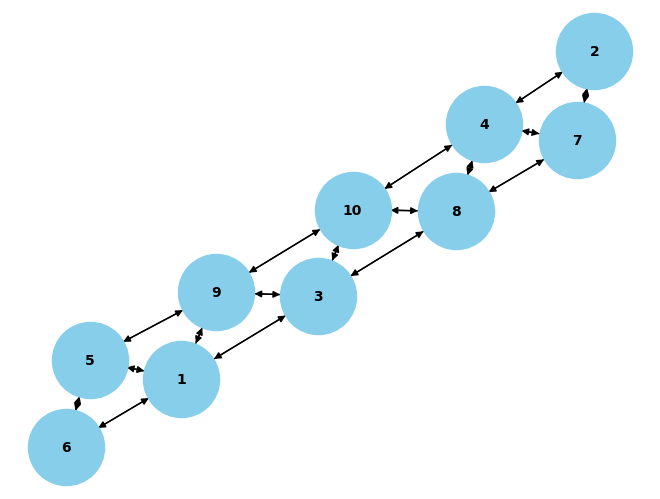

In [58]:
#test make_pairs
from dust3r.image_pairs import make_pairs
from viz_graph import viz_graph

scene_graph_params = [scenegraph_type]
if scenegraph_type in ["swin", "logwin"]:
    scene_graph_params.append(str(winsize))
elif scenegraph_type == "oneref":
    scene_graph_params.append(str(refid))
if scenegraph_type in ["swin", "logwin"] and not win_cyclic:
    scene_graph_params.append('noncyclic')
scene_graph = '-'.join(scene_graph_params)

pairs = make_pairs(imgs, scene_graph=scene_graph, prefilter=None, symmetrize=True)

print("len of pairs", len(pairs))

file_names = [im["path"] for im in imgs]

viz_graph(file_names, pairs)

In [64]:

# cache to store previous inference results
cache_dir = os.path.join(outdir, 'cache')
os.makedirs(cache_dir, exist_ok=True)

# optimization level
optim_level = "refine"
niter2 = 0 if optim_level == "coarse" else 200

scene = sparse_global_alignment(filelist, pairs, cache_dir,
                                    model, lr1=0.07 , niter1=500, lr2=0.014, niter2=niter2, device=device,
                                    opt_depth='depth' in optim_level, shared_intrinsics=True,
                                    matching_conf_thr=0.5)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 4783.68it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 25.08it/s]


init focal (shared) =  397.15


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:18<00:00, 27.01it/s, lr=0.0000, loss=0.064]


>> final loss = 0.06414733082056046


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:14<00:00, 13.53it/s, lr=0.0000, loss=0.937]

>> final loss = 0.9369211196899414
Final focal (shared) =  409.98


In [108]:
# save mat file

#unpack scene
#scene = scene.sparse_ga

mask = to_numpy(scene.get_masks())
pts3d, depthmaps, confs = to_numpy(scene.get_dense_pts3d(clean_depth=True))
pts3d_clr = to_numpy(scene.get_pts3d_colors())

rgbimgs = scene.imgs
focals = scene.get_focals().cpu()
cams2world = scene.get_im_poses().cpu()

pts3d = np.concatenate([p[m] for p, m in zip(pts3d, mask)])

pts3d_clr = np.concatenate([p[m] for p, m in zip(rgbimgs, mask)])
pts3d_clr = pts3d_clr.reshape(-1,3)

confs_wrld = np.concatenate([p[m] for p, m in zip(confs, mask)])
confs_wrld = confs_wrld.reshape(-1,1) / np.max(confs_wrld)

# create a dict about world info
wrld_info = {
    'wrld': {
        'xyz': pts3d,
        'color': pts3d_clr,
        'conf': confs_wrld, 
    }
}
savemat(outdir + '/wrld_info.mat', wrld_info)

cell_array = np.empty((len(cams2world), 1), dtype=object)
for i in range(0,cell_array.shape[0]):
    cell_array[i,0] = {
        'extrinsics': to_numpy(cams2world[i]),
        'intrinsics': to_numpy(scene.get_focals().cpu()[i]),
        'rgb': to_numpy(rgbimgs[i]),
        'depth': np.reshape(depthmaps[i], (to_numpy(rgbimgs[i]).shape[0], to_numpy(rgbimgs[i]).shape[1])),
        'conf': confs[i]
    }
data = {
    'cams_info': cell_array  # Saving the cell array as 'myCellArray'
}
savemat(outdir + '/cams_info.mat', data)


/home/manuelf/mast3r/mast3r/cloud_opt/sparse_ga.py:77: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  (canon, canon2, conf), focal = torch.load(canon_path, map_location=devic

In [107]:
# save a pcd file with open3d

from pypcd4 import PointCloud

conf_threshold = 0.2
rgb_unit8 = np.array([PointCloud.encode_rgb(np.array(pts3d_clr*255).astype(np.uint8))]).T
pc = PointCloud.from_xyzrgb_points(np.hstack([pts3d[(confs_wrld > conf_threshold).squeeze() , :], rgb_unit8[(confs_wrld > conf_threshold).squeeze(),:]]))

pc.save(outdir + '/scene.pcd')
